In [1]:
# Import necessary modules
from pathlib import Path
from typing import Optional
import pandas as pd
import torch
import torchio as tio

from vascular_superenhancement.training.datasets import make_subject, build_subjects_dataset
from vascular_superenhancement.data_management.patients import Patient
from vascular_superenhancement.utils.path_config import load_path_config
from vascular_superenhancement.training.transforms import build_transforms
from vascular_superenhancement.training.transforms import build_transforms
from vascular_superenhancement.training.dataloading import build_train_loader


# test datasets.make_subject

In [2]:
# 1. First, let's test make_subject with a single patient and timepoint
def test_make_subject(
    phonetic_id: Optional [str] = 'Bukrukesh'):
    # Load path configuration
    path_config = load_path_config("all_patients")  # or your specific config name
    
    # Create a test patient
    patient = Patient(
        path_config=path_config,
        phonetic_id=phonetic_id,  # or use an actual patient ID from your dataset
        debug=True  # Enable debug logging
    )
    
    # Test with first timepoint
    time_index = 0
    
    # Create subject without transforms
    subject = make_subject(patient, time_index)
    
    # Print subject information
    print(f"Subject name: {subject.name}")
    print(f"Available images: {list(subject.get_images_dict().keys())}")
    
    # Check if all required images are present
    required_images = ['cine', 'mag', 'fvx', 'fvy', 'fvz']
    for img_name in required_images:
        assert img_name in subject.get_images_dict(), f"Missing {img_name} image"
    
    # Visualize each image in the subject
    for name, image in subject.get_images_dict().items():
        print(f"\nVisualizing {name}:")
        image.plot()  # This will show the image with interactive controls
    
    return subject

Testing make_subject
Patient Bukrukesh log file: /home/ayeluru/vascular-superenhancement-4d-flow/working_dir/sample_patients/logs/patients/Bukrukesh.log
Subject name: Bukrukesh_00
Available images: ['mag', 'fvx', 'fvy', 'fvz', 'cine']

Visualizing mag:


2025-05-20 17:20:35,932 - DEBUG - Converted 3D Cine series number to integer: 1600
2025-05-20 17:20:35,932 - INFO - Successfully loaded patient information from database


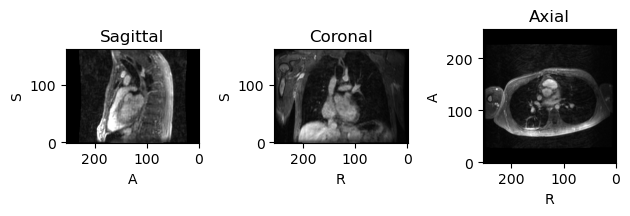


Visualizing fvx:


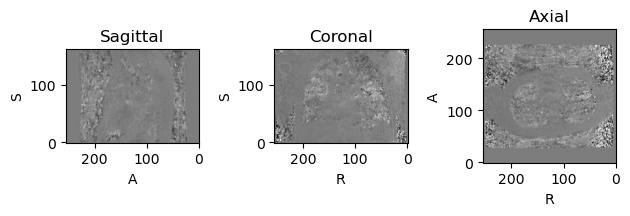


Visualizing fvy:


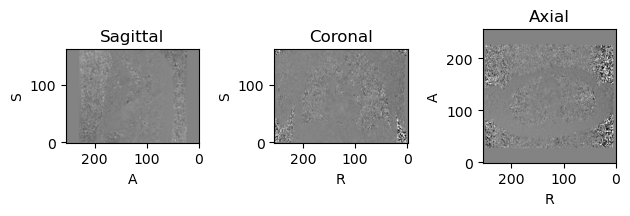


Visualizing fvz:


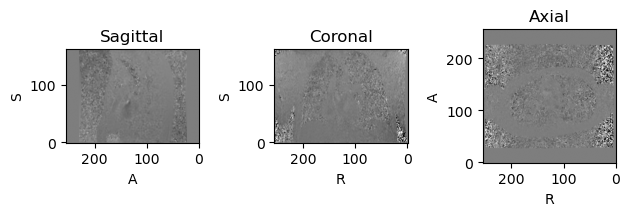


Visualizing cine:


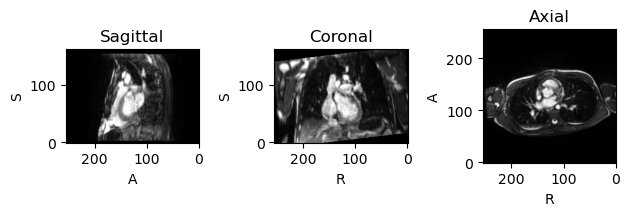

In [15]:
print("Testing make_subject")
subject = test_make_subject()


# test datasets.build_subjects_dataset

In [2]:
# 2. Now let's test build_subjects_dataset
def test_build_subjects_dataset():    
    test_split_path = Path('/home/ayeluru/vascular-superenhancement-4d-flow/splits/splits_05-20-25.csv')
    
    # Build dataset for training split
    dataset = build_subjects_dataset(
        split='val',
        split_csv_path=test_split_path,
        path_config='all_patients'
    )

    # Print dataset information
    print(f"Dataset size: {len(dataset)}")
    print(f"First subject name: {dataset[100].name}")
    
    # for subject in dataset:
    #     print(f"Subject name: {subject.name}")
    #     print(f"Available images: {list(subject.get_images_dict().keys())}")
    
    # Visualize the first subject in the dataset
    for name, image in dataset[100].get_images_dict().items():
        print(f"\nVisualizing {name}:")
        image.plot()  # This will show the image with interactive controls
    
    return dataset

Testing build_subjects_dataset


2025-05-20 18:15:04,752 - INFO - Added 20 subjects for patient Badiswu
2025-05-20 18:15:05,561 - INFO - Added 20 subjects for patient Bibathot
2025-05-20 18:15:06,411 - INFO - Added 20 subjects for patient Bukrukesh
2025-05-20 18:15:07,220 - INFO - Added 20 subjects for patient Butiswu
2025-05-20 18:15:08,073 - INFO - Added 20 subjects for patient Cadedag
2025-05-20 18:15:08,933 - INFO - Added 20 subjects for patient Cefaru
2025-05-20 18:15:09,796 - INFO - Added 20 subjects for patient Cemuquey
2025-05-20 18:15:10,925 - INFO - Added 20 subjects for patient Ceriba
2025-05-20 18:15:11,714 - INFO - Added 20 subjects for patient Dalibul
2025-05-20 18:15:12,515 - INFO - Added 20 subjects for patient Dapafem
2025-05-20 18:15:13,610 - INFO - Added 20 subjects for patient Datokif
2025-05-20 18:15:14,646 - INFO - Added 20 subjects for patient Desoomi
2025-05-20 18:15:15,763 - INFO - Added 20 subjects for patient Difresa
2025-05-20 18:15:16,640 - INFO - Added 20 subjects for patient Dinaspig
202

Dataset size: 2120
First subject name: Badiswu_00

Visualizing mag:


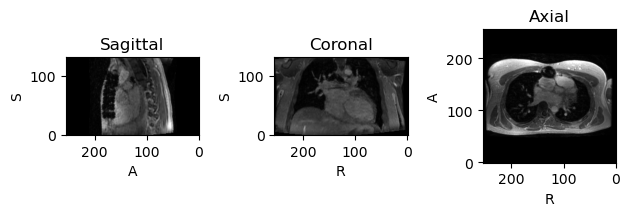


Visualizing fvx:


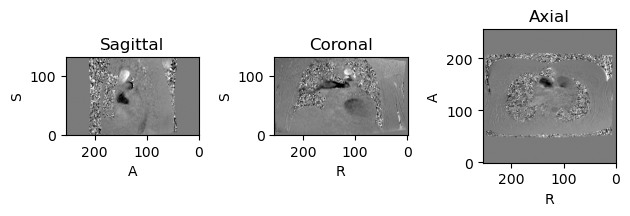


Visualizing fvy:


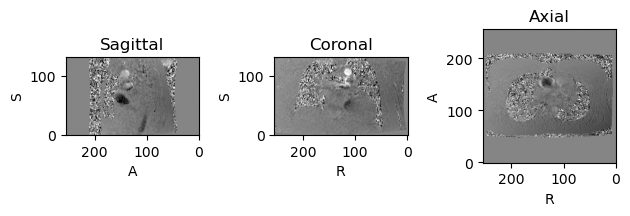


Visualizing fvz:


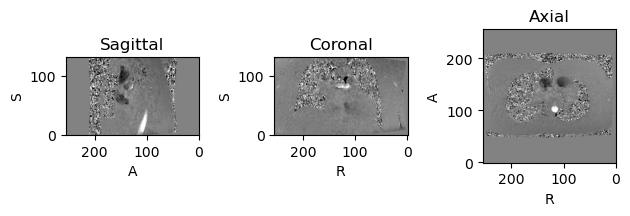


Visualizing cine:


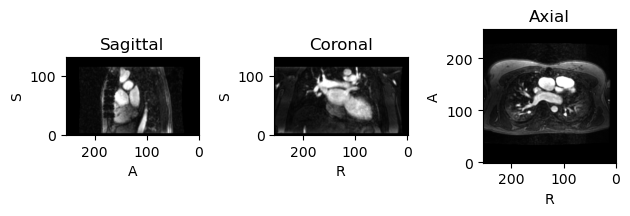

In [3]:

print("Testing build_subjects_dataset")
dataset = test_build_subjects_dataset()

# test transforms.build_transforms on a subject

In [7]:
def test_transforms(train: bool = True):
    # Create a mock config object with required parameters
    class MockConfig:
        class TrainConfig:
            patch_size = [96, 96, 96]
        class DataConfig:
            spacing = [1, 1, 1]#[1.4, 1.4, 1.4]
        train = TrainConfig()
        data = DataConfig()
    
    cfg = MockConfig()
    
    # Build transforms
    transforms = build_transforms(cfg, train=train)
    
    # Create a test subject with random data
    # Shape: [1, 128, 128, 128] for each image (batch, height, width, depth)
    path_config = load_path_config("all_patients")  # or your specific config name
    
    # Create a test patient
    patient = Patient(
        path_config=path_config,
        phonetic_id='Bukrukesh',  # or use an actual patient ID from your dataset
        debug=False  # Enable debug logging
    )
    
    time_index = 0
    
    # Create subject without transforms
    subject = make_subject(patient, time_index)        
        
    # for name, image in subject.get_images_dict().items():
    #     print(f"\nVisualizing {name}:")
    #     image.plot()
    
    # Apply transforms
    transformed = transforms(subject)
    
    # for name, image in transformed.get_images_dict().items():
    #     print(f"\nVisualizing {name}:")
    #     image.plot()
    
    # Test 1: Check that all images are present
    assert all(key in transformed.get_images_dict().keys() for key in subject.get_images_dict().keys()), "Missing images after transform"
    
    # Test 2: Check that images have been resampled to target spacing
    for name, image in subject.get_images_dict().items():
        print(image.shape)
        print(image.affine)
        # Note: Actual spacing check would require access to the image's affine matrix
    
    for name, image in transformed.get_images_dict().items():
        print(image.shape)
        print(image.affine)
        assert isinstance(image, tio.ScalarImage), f"{name} is not a ScalarImage"
        # Note: Actual spacing check would require access to the image's affine matrix
    
    # Test 3: Check that images range from 0 to 1
    for name, image in subject.get_images_dict().items():
        data = image.data
        min_val = data.min().item()
        max_val = data.max().item()
        print(f"{name} min: {min_val}, max: {max_val}")
                
    for name, image in transformed.get_images_dict().items():
        data = image.data
        min_val = data.min().item()
        max_val = data.max().item()
        print(f"{name} min: {min_val}, max: {max_val}")
        # mag and cine are normalized to [0, 1]
        # flow_vx, flow_vy, flow_vz are normalized to [-1, 1]
        if name in ["mag", "cine"]:
            assert min_val >= 0 and max_val <= 1, f"{name} values are not in the range [0, 1], min: {min_val}, max: {max_val}"
        elif name in ["flow_vx", "flow_vy", "flow_vz"]:
            assert min_val >= -1 and max_val <= 1, f"{name} values are not in the range [-1, 1], min: {min_val}, max: {max_val}"
    
    # # Test 4: Check that images have been cropped/padded to patch size
    # for key in transformed.get_images_dict().items():
    #     data = transformed[key].data
    #     assert data.shape[1:] == tuple(cfg.train.patch_size), \
    #         f"{key} shape {data.shape[1:]} doesn't match patch size {cfg.train.patch_size}"
    
    # # Test 5: Check that the transform pipeline is deterministic
    # transformed2 = transforms(subject)
    # for key in transformed.get_images_dict().items():
    #     assert torch.allclose(transformed[key].data, transformed2[key].data), \
    #         f"{key} transform is not deterministic"
    
    print("All transform tests passed!")
    return transformed


In [3]:
# Run the test
transformed_subject = test_transforms(train=True)
    
# # Optional: Visualize the results
# for key in transformed_subject.keys():
#     print(f"\nVisualizing {key}:")
#     transformed_subject[key].plot()

(1, 256, 256, 162)
[[ -1.44531441   0.           0.         156.51899719]
 [  0.          -1.44531441   0.         191.977005  ]
 [  0.           0.           1.60003197 -88.11000061]
 [  0.           0.           0.           1.        ]]
(1, 256, 256, 162)
[[ -1.44531441   0.           0.         156.51899719]
 [  0.          -1.44531441   0.         191.977005  ]
 [  0.           0.           1.60003197 -88.11000061]
 [  0.           0.           0.           1.        ]]
(1, 256, 256, 162)
[[ -1.44531441   0.           0.         156.51899719]
 [  0.          -1.44531441   0.         191.977005  ]
 [  0.           0.           1.60003197 -88.11000061]
 [  0.           0.           0.           1.        ]]
(1, 256, 256, 162)
[[ -1.44531441   0.           0.         156.51899719]
 [  0.          -1.44531441   0.         191.977005  ]
 [  0.           0.           1.60003197 -88.11000061]
 [  0.           0.           0.           1.        ]]
(1, 256, 256, 162)
[[ -1.44531441   0.  

# test transforms.build_transforms on a dataset

In [8]:
def test_build_subjects_dataset(train: bool = True):    
    test_split_path = Path('/home/ayeluru/vascular-superenhancement-4d-flow/splits/splits_05-20-25.csv')
    
    class MockConfig:
        class TrainConfig:
            patch_size = [96, 96, 96]
        class DataConfig:
            spacing = [1, 1, 1]#[1.4, 1.4, 1.4]
        train = TrainConfig()
        data = DataConfig()
    
    cfg = MockConfig()
    
    # Build transforms
    transforms = build_transforms(cfg, train=train)
    
    # Build dataset for training split
    dataset = build_subjects_dataset(
        split='train',
        split_csv_path=test_split_path,
        path_config='all_patients',
        transforms=transforms
    )

    # Print dataset information
    print(f"Dataset size: {len(dataset)}")
    print(f"First subject name: {dataset[100].name}")
    
    # for subject in dataset:
    #     print(f"Subject name: {subject.name}")
    #     print(f"Available images: {list(subject.get_images_dict().keys())}")
    
    # Visualize the first subject in the dataset
    for name, image in dataset[100].get_images_dict().items():
        print(f"\nVisualizing {name}:")
        image.plot()  # This will show the image with interactive controls
    
    return dataset

Testing build_subjects_dataset


2025-05-20 22:34:20,995 - INFO - Added 20 subjects for patient Badiswu
2025-05-20 22:34:21,810 - INFO - Added 20 subjects for patient Bibathot
2025-05-20 22:34:22,626 - INFO - Added 20 subjects for patient Bukrukesh
2025-05-20 22:34:23,442 - INFO - Added 20 subjects for patient Butiswu
2025-05-20 22:34:24,258 - INFO - Added 20 subjects for patient Cadedag
2025-05-20 22:34:25,073 - INFO - Added 20 subjects for patient Cefaru
2025-05-20 22:34:25,890 - INFO - Added 20 subjects for patient Cemuquey
2025-05-20 22:34:26,705 - INFO - Added 20 subjects for patient Ceriba
2025-05-20 22:34:27,520 - INFO - Added 20 subjects for patient Dalibul
2025-05-20 22:34:28,338 - INFO - Added 20 subjects for patient Dapafem
2025-05-20 22:34:29,151 - INFO - Added 20 subjects for patient Datokif
2025-05-20 22:34:29,967 - INFO - Added 20 subjects for patient Desoomi
2025-05-20 22:34:30,782 - INFO - Added 20 subjects for patient Difresa
2025-05-20 22:34:31,599 - INFO - Added 20 subjects for patient Dinaspig
202

Dataset size: 2120
First subject name: Cefaru_00

Visualizing mag:


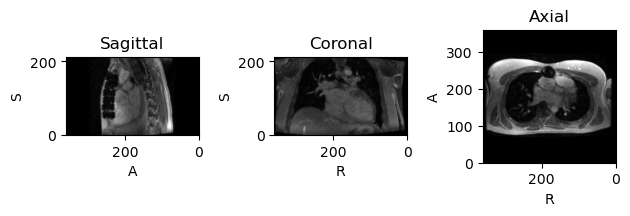


Visualizing flow_vx:


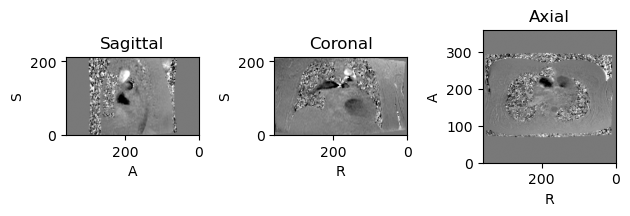


Visualizing flow_vy:


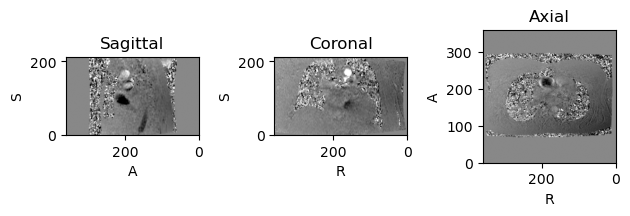


Visualizing flow_vz:


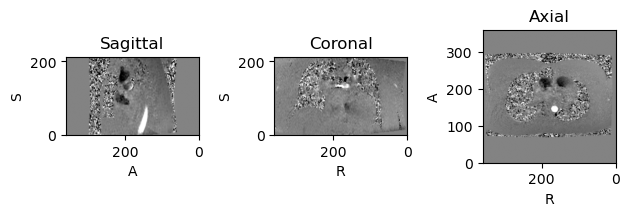


Visualizing cine:


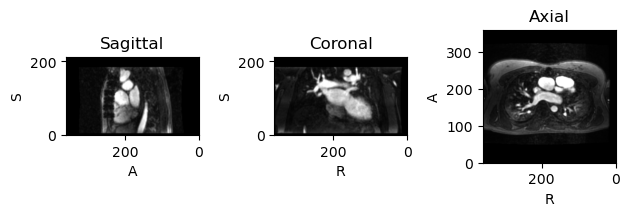

In [9]:

print("Testing build_subjects_dataset")
dataset = test_build_subjects_dataset()

(1, 361, 361, 212)
[[ -1.           0.           0.         154.06912273]
 [  0.          -1.           0.         154.50012249]
 [  0.           0.           1.         -57.88744551]
 [  0.           0.           0.           1.        ]]
(1, 361, 361, 212)
[[ -1.           0.           0.         154.06912273]
 [  0.          -1.           0.         154.50012249]
 [  0.           0.           1.         -57.88744551]
 [  0.           0.           0.           1.        ]]
(1, 361, 361, 212)
[[ -1.           0.           0.         154.06912273]
 [  0.          -1.           0.         154.50012249]
 [  0.           0.           1.         -57.88744551]
 [  0.           0.           0.           1.        ]]
(1, 361, 361, 212)
[[ -1.           0.           0.         154.06912273]
 [  0.          -1.           0.         154.50012249]
 [  0.           0.           1.         -57.88744551]
 [  0.           0.           0.           1.        ]]
(1, 361, 361, 212)
[[ -1.           0.  

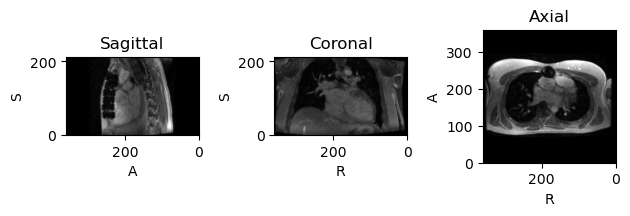

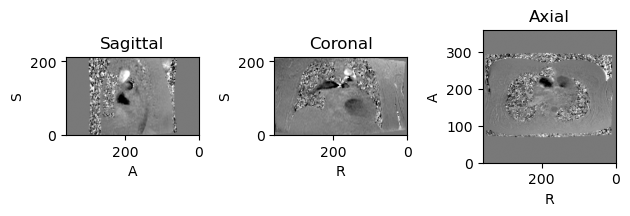

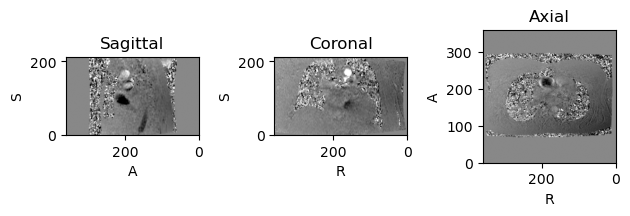

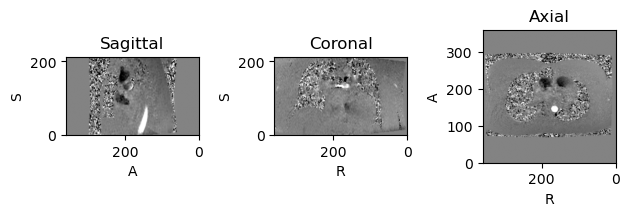

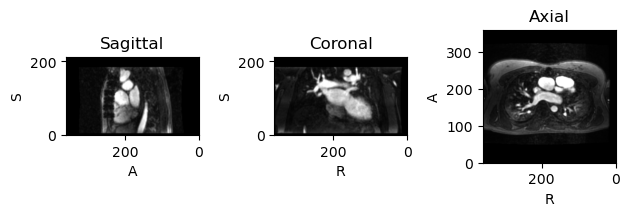

In [11]:
transformed = dataset[100]
# Test 1: Check that all images are present
# Test 2: Check that images have been resampled to target spacing

for name, image in transformed.get_images_dict().items():
    print(image.shape)
    print(image.affine)
    assert isinstance(image, tio.ScalarImage), f"{name} is not a ScalarImage"
    # Note: Actual spacing check would require access to the image's affine matrix

# Test 3: Check that images range from 0 to 1
            
for name, image in transformed.get_images_dict().items():
    data = image.data
    min_val = data.min().item()
    max_val = data.max().item()
    print(f"{name} min: {min_val}, max: {max_val}")
    # mag and cine are normalized to [0, 1]
    # flow_vx, flow_vy, flow_vz are normalized to [-1, 1]
    if name in ["mag", "cine"]:
        assert min_val >= 0 and max_val <= 1, f"{name} values are not in the range [0, 1], min: {min_val}, max: {max_val}"
    elif name in ["flow_vx", "flow_vy", "flow_vz"]:
        assert min_val >= -1 and max_val <= 1, f"{name} values are not in the range [-1, 1], min: {min_val}, max: {max_val}"
        
for name, image in transformed.get_images_dict().items():
    image.plot()

# test dataloading.build_train_loader on a dataset


2025-05-20 23:51:47,909 - INFO - Added 20 subjects for patient Apuefquor
2025-05-20 23:51:48,527 - INFO - Added 20 subjects for patient Gemapoey
2025-05-20 23:51:49,146 - INFO - Added 20 subjects for patient Grefuci
2025-05-20 23:51:49,762 - INFO - Added 20 subjects for patient Kacague
2025-05-20 23:51:50,378 - INFO - Added 20 subjects for patient Kadiforn
2025-05-20 23:51:50,996 - INFO - Added 20 subjects for patient Senaniel
2025-05-20 23:51:51,615 - INFO - Added 20 subjects for patient Somenut
2025-05-20 23:51:52,234 - INFO - Added 20 subjects for patient Suedrurnep
2025-05-20 23:51:52,854 - INFO - Added 20 subjects for patient Tiphemik
2025-05-20 23:51:53,472 - INFO - Added 20 subjects for patient Ugitat
2025-05-20 23:51:54,093 - INFO - Added 20 subjects for patient Upbapit


Dataset size: 220
First subject name: Senaniel_00

Visualizing mag:


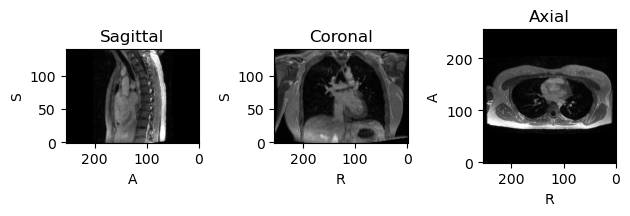


Visualizing flow_vx:


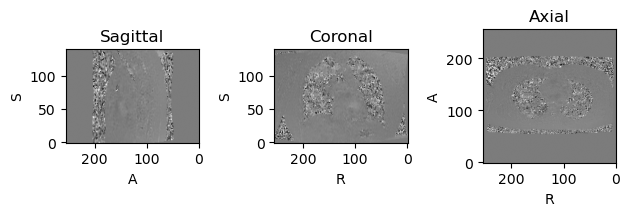


Visualizing flow_vy:


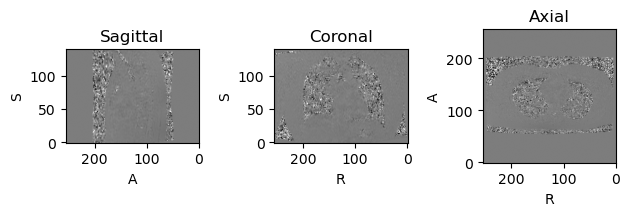


Visualizing flow_vz:


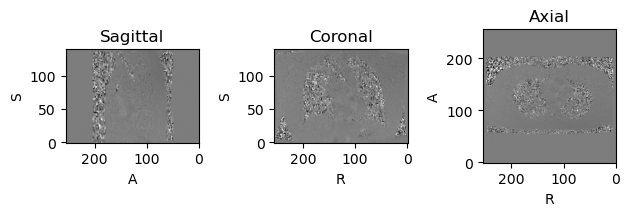


Visualizing cine:


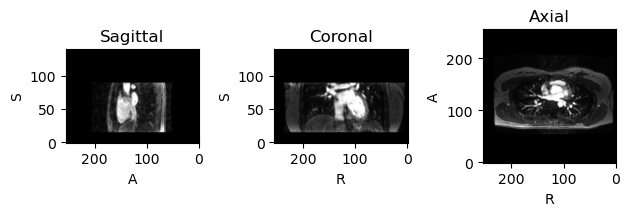

In [3]:
dataset = test_build_subjects_dataset()

In [13]:
def test_build_train_loader(dataset: tio.SubjectsDataset):
    class MockConfig:
        class TrainConfig:
            patch_size = [96, 96, 96]
            queue_length = 100
            samples_per_volume = 8
            num_queue_workers = 4
            num_loader_workers = 0
            batch_size = 8
        class DataConfig:
            spacing = [1, 1, 1]#[1.4, 1.4, 1.4]
            
        train = TrainConfig()
        data = DataConfig()
    
    cfg = MockConfig()
    augmentations = build_transforms(cfg, train=True)
    loader = build_train_loader(dataset, cfg, augmentations)
    return loader



In [14]:
import matplotlib.pyplot as plt

loader = test_build_train_loader(dataset)


In [16]:
print(type(batch['mag']))
print(batch['mag'].keys())
print(batch['mag']['stem'])

<class 'dict'>
dict_keys(['path', 'stem', 'type', 'data', 'affine'])
['4d_flow_mag_Tiphemik_frame_12', '4d_flow_mag_Tiphemik_frame_14', '4d_flow_mag_Suedrurnep_frame_16', '4d_flow_mag_Grefuci_frame_04', '4d_flow_mag_Tiphemik_frame_14', '4d_flow_mag_Ugitat_frame_19', '4d_flow_mag_Ugitat_frame_04', '4d_flow_mag_Gemapoey_frame_08']


torch.Size([8, 1, 96, 96, 96])
torch.Size([8, 1, 96, 96, 96])


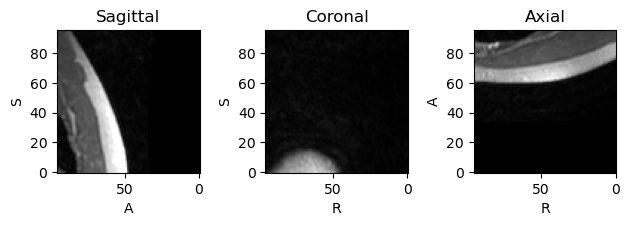

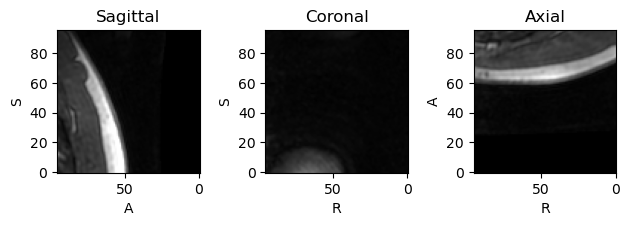

torch.Size([8, 1, 96, 96, 96])
torch.Size([8, 1, 96, 96, 96])


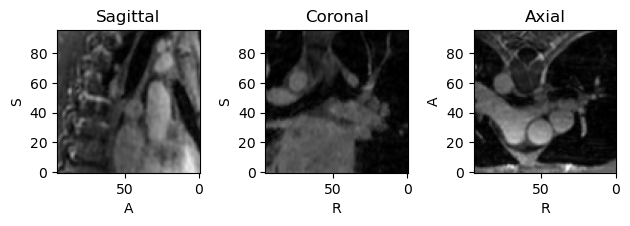

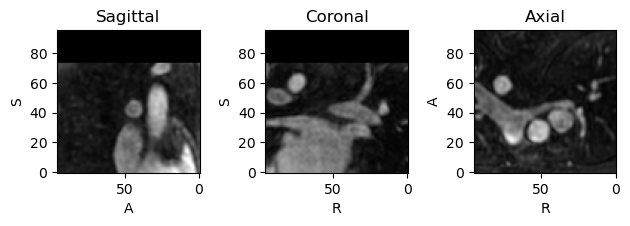

torch.Size([8, 1, 96, 96, 96])
torch.Size([8, 1, 96, 96, 96])


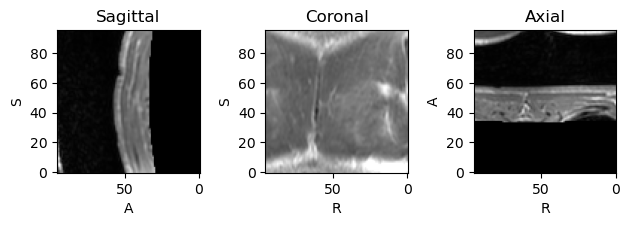

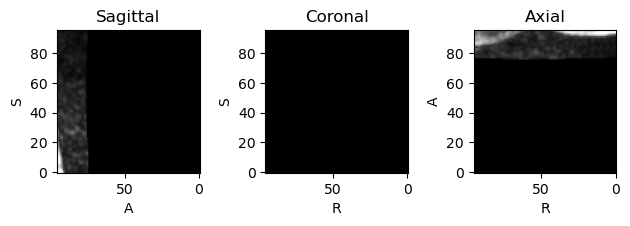

torch.Size([8, 1, 96, 96, 96])
torch.Size([8, 1, 96, 96, 96])


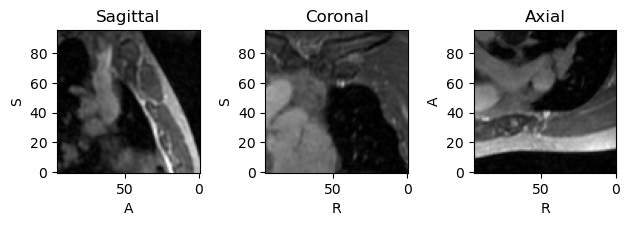

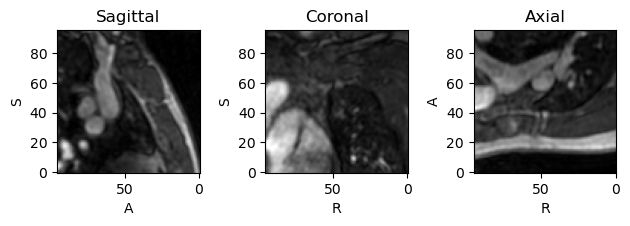

torch.Size([8, 1, 96, 96, 96])
torch.Size([8, 1, 96, 96, 96])


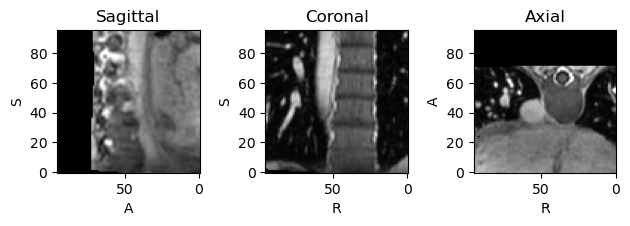

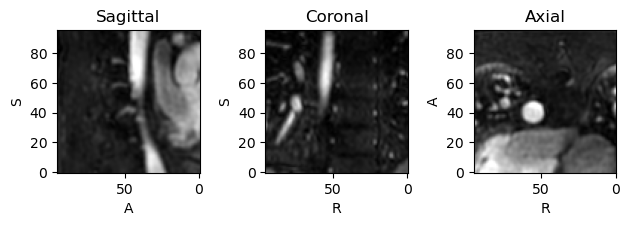

torch.Size([8, 1, 96, 96, 96])
torch.Size([8, 1, 96, 96, 96])


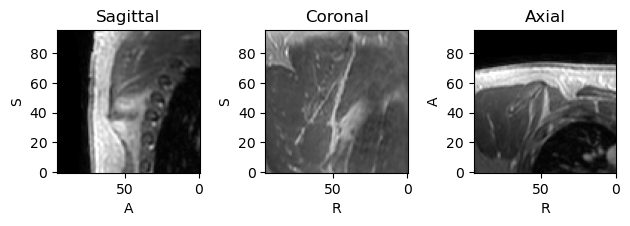

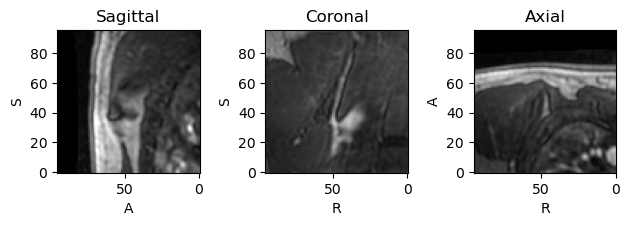

torch.Size([8, 1, 96, 96, 96])
torch.Size([8, 1, 96, 96, 96])


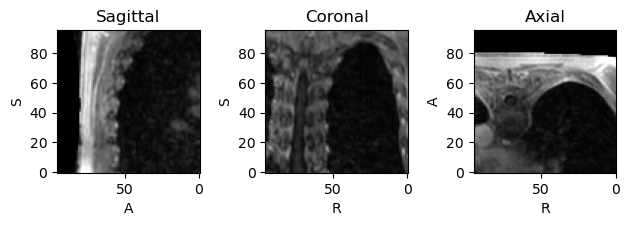

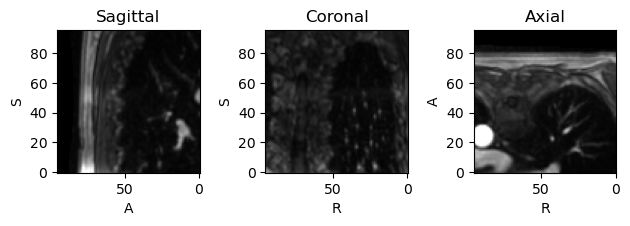

torch.Size([8, 1, 96, 96, 96])
torch.Size([8, 1, 96, 96, 96])


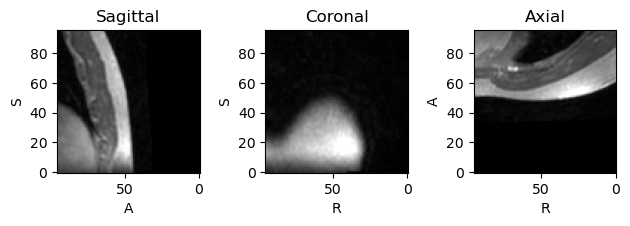

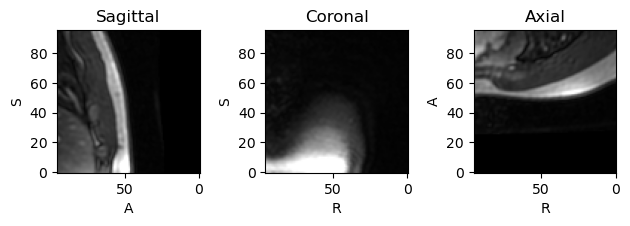

torch.Size([8, 1, 96, 96, 96])
torch.Size([8, 1, 96, 96, 96])


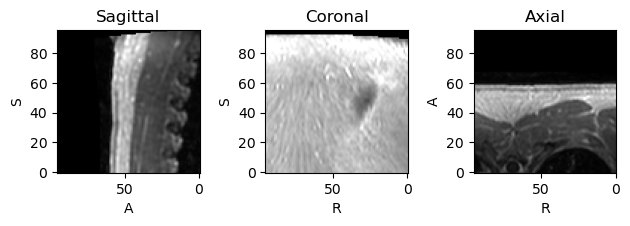

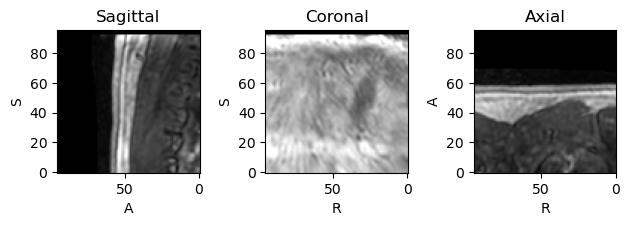

torch.Size([8, 1, 96, 96, 96])
torch.Size([8, 1, 96, 96, 96])


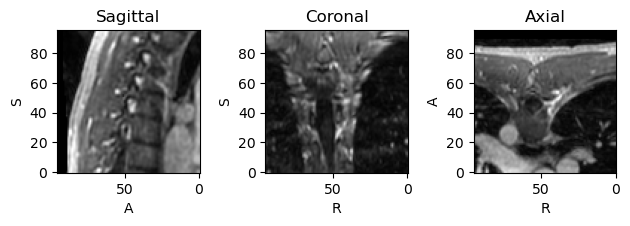

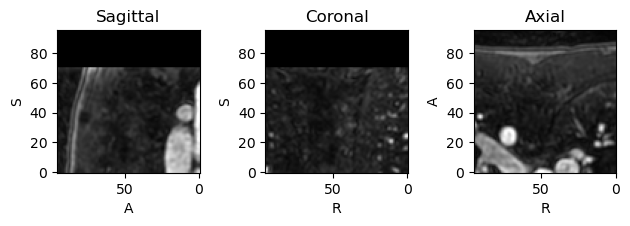

In [21]:
how_many_batches = 10
for batch in loader:
    inputs = batch['mag'][tio.DATA]
    outputs = batch['cine'][tio.DATA]
    print(inputs.shape)
    print(outputs.shape)
    
    image_input = tio.ScalarImage(tensor=inputs[0])
    image_input.plot()
    
    image_output = tio.ScalarImage(tensor=outputs[0])
    image_output.plot()
    
    how_many_batches -= 1
    if how_many_batches == 0:
        break  # only do one batch
